# TB Detection with HeAR and UCSF R2D2 Dataset

This notebook demonstrates how to use the HeAR (Health Acoustic Representations) model embeddings for TB detection using the UCSF R2D2 dataset. The notebook focuses on building a robust TB classifier system using pre-computed HeAR embeddings.

**Key Features:**
- Uses pre-computed HeAR embeddings from UCSF R2D2 dataset (19,323 samples)
- Compares 5 different machine learning models
- Addresses class imbalance (TB Positive: 2.6% vs TB Negative: 87.4%)
- Comprehensive evaluation with clinical-relevant metrics

#### Here's a breakdown of the notebook's steps:

1. **Data Loading:** Load pre-computed HeAR embeddings and TB labels from UCSF R2D2 dataset
2. **Data Preprocessing:** Handle class imbalance and prepare train/test splits
3. **Model Training:** Train 5 different classifiers optimized for imbalanced data:
   - Support Vector Machine (linear kernel) with class weighting
   - Logistic Regression with balanced class weights
   - Gradient Boosting with scale_pos_weight
   - Random Forest with balanced_subsample
   - XGBoost with scale_pos_weight
4. **Model Evaluation:** Comprehensive evaluation using TB-relevant metrics:
   - Sensitivity (critical for TB detection)
   - Specificity and NPV
   - F2-Score (emphasizes recall)
   - PR-AUC (better than ROC-AUC for imbalanced data)
   - Confusion matrices and error analysis
5. **Comparative Analysis:** Side-by-side comparison of all models with recommendations

## Setup and Data Loading

In [7]:
!brew install libomp

To reinstall 20.1.8, run:
  brew reinstall libomp


In [8]:
!pip install xgboost

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    precision_recall_curve, f1_score, fbeta_score, roc_auc_score,
    accuracy_score, precision_score, recall_score
)
from sklearn.utils.class_weight import compute_class_weight

# Try to import XGBoost, fall back to Extra Trees if not available
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    from sklearn.ensemble import ExtraTreesClassifier
    XGBOOST_AVAILABLE = False
    print("XGBoost not available, using ExtraTreesClassifier instead")

print("✅ All libraries loaded successfully")

✅ All libraries loaded successfully


## Load UCSF R2D2 Embeddings and Labels

In [10]:
def load_embeddings_with_labels(embedding_path, metadata_path, max_rows=None):
    """
    Load HeAR embeddings and TB labels from UCSF R2D2 dataset
    """
    print("🔄 Loading UCSF R2D2 embeddings and labels...")
    
    # Load embeddings
    embeddings = np.load(embedding_path)
    print(f"📊 Loaded {len(embeddings)} embedding files")
    
    # Load metadata with TB labels
    metadata = pd.read_csv(metadata_path)
    if max_rows:
        metadata = metadata.head(max_rows)
    
    # Create full file keys for matching
    metadata['full_key'] = metadata['patientID'] + '/' + metadata['filename']
    
    # Map TB labels to binary values
    label_map = {"TB Positive": 1, "TB Negative": 0}
    
    X, y, keys = [], [], []
    missing_files = 0
    
    for _, row in metadata.iterrows():
        key = row['full_key']
        if key in embeddings and row['label'] in label_map:
            # Average embeddings across clips for each file
            emb = embeddings[key]
            emb_mean = np.mean(emb, axis=0)
            X.append(emb_mean)
            y.append(label_map[row['label']])
            keys.append(key)
        else:
            missing_files += 1
    
    print(f"✅ Processed {len(X)} samples ({missing_files} files not found)")
    print(f"📈 TB Positive: {sum(y)} ({sum(y)/len(y)*100:.1f}%)")
    print(f"📉 TB Negative: {len(y)-sum(y)} ({(len(y)-sum(y))/len(y)*100:.1f}%)")
    
    return np.array(X), np.array(y), keys

# Load the data
EMBEDDING_PATH = "../01_data_processing/data/audium_UCSF_embeddings.npz"
METADATA_PATH = "../r2d2_audio_index_with_labels.csv"

X, y, file_keys = load_embeddings_with_labels(EMBEDDING_PATH, METADATA_PATH)
print(f"\n🎯 Final dataset shape: {X.shape}")
print(f"🎯 Class distribution: {Counter(y)}")

🔄 Loading UCSF R2D2 embeddings and labels...
📊 Loaded 19484 embedding files
✅ Processed 19323 samples (475 files not found)
📈 TB Positive: 2505 (13.0%)
📉 TB Negative: 16818 (87.0%)

🎯 Final dataset shape: (19323, 1024)
🎯 Class distribution: Counter({np.int64(0): 16818, np.int64(1): 2505})


## Data Preprocessing and Class Imbalance Handling

📊 Class weights: {np.int64(0): np.float64(0.5744737780948983), np.int64(1): np.float64(3.8568862275449103)}
📊 Scale pos weight (for XGBoost): 0.15

🔄 Train set: (15458, 1024), TB Positive: 2004 (13.0%)
🔄 Test set: (3865, 1024), TB Positive: 501 (13.0%)


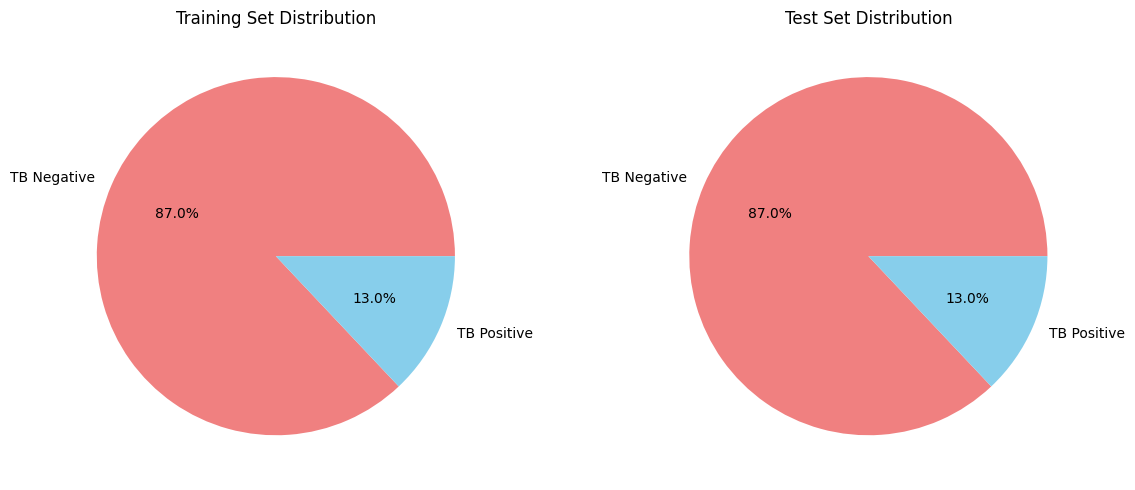

In [11]:
# Calculate class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))
scale_pos_weight = class_weights[0] / class_weights[1]  # For XGBoost

print(f"📊 Class weights: {class_weight_dict}")
print(f"📊 Scale pos weight (for XGBoost): {scale_pos_weight:.2f}")

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Feature scaling (important for SVM and Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n🔄 Train set: {X_train.shape}, TB Positive: {sum(y_train)} ({sum(y_train)/len(y_train)*100:.1f}%)")
print(f"🔄 Test set: {X_test.shape}, TB Positive: {sum(y_test)} ({sum(y_test)/len(y_test)*100:.1f}%)")

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training set distribution
train_counts = Counter(y_train)
ax1.pie(train_counts.values(), labels=['TB Negative', 'TB Positive'], autopct='%1.1f%%', colors=['lightcoral', 'skyblue'])
ax1.set_title('Training Set Distribution')

# Test set distribution
test_counts = Counter(y_test)
ax2.pie(test_counts.values(), labels=['TB Negative', 'TB Positive'], autopct='%1.1f%%', colors=['lightcoral', 'skyblue'])
ax2.set_title('Test Set Distribution')

plt.tight_layout()
plt.show()

## Model Configuration - 5 Classifiers Optimized for Imbalanced Data

In [12]:
# Define models optimized for class imbalance
if XGBOOST_AVAILABLE:
    models = {
        "Support Vector Machine (linear)": SVC(
            kernel='linear', 
            probability=True, 
            class_weight='balanced',
            random_state=42
        ),
        "Logistic Regression": LogisticRegression(
            max_iter=1000, 
            class_weight='balanced',
            random_state=42
        ),
        "Gradient Boosting": GradientBoostingClassifier(
            n_estimators=128,
            random_state=42
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=128,
            class_weight='balanced_subsample',
            random_state=42
        ),
        "XGBoost": XGBClassifier(
            n_estimators=128,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            eval_metric='logloss'
        )
    }
else:
    models = {
        "Support Vector Machine (linear)": SVC(
            kernel='linear', 
            probability=True, 
            class_weight='balanced',
            random_state=42
        ),
        "Logistic Regression": LogisticRegression(
            max_iter=1000, 
            class_weight='balanced',
            random_state=42
        ),
        "Gradient Boosting": GradientBoostingClassifier(
            n_estimators=128,
            random_state=42
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=128,
            class_weight='balanced_subsample',
            random_state=42
        ),
        "Extra Trees": ExtraTreesClassifier(
            n_estimators=128,
            class_weight='balanced',
            random_state=42
        )
    }

print(f"🤖 Configured {len(models)} models for TB detection:")
for name in models.keys():
    print(f"  - {name}")

🤖 Configured 5 models for TB detection:
  - Support Vector Machine (linear)
  - Logistic Regression
  - Gradient Boosting
  - Random Forest
  - XGBoost


## Model Training with Clinical Focus

In [13]:
%%time
trained_models = {}
training_scores = {}

print("🚀 Training models optimized for TB detection...\n")

for name, model in models.items():
    print(f"🔄 Training: {name}")
    
    # Use scaled features for models that benefit from it
    if 'SVM' in name or 'Logistic' in name:
        model.fit(X_train_scaled, y_train)
    else:
        model.fit(X_train, y_train)
    
    trained_models[name] = model
    
    # Quick training score check
    if 'SVM' in name or 'Logistic' in name:
        train_score = model.score(X_train_scaled, y_train)
    else:
        train_score = model.score(X_train, y_train)
    
    training_scores[name] = train_score
    print(f"  ✅ Training accuracy: {train_score:.3f}")

print(f"\n🎯 All {len(trained_models)} models trained successfully!")

🚀 Training models optimized for TB detection...

🔄 Training: Support Vector Machine (linear)
  ✅ Training accuracy: 0.634
🔄 Training: Logistic Regression
  ✅ Training accuracy: 0.657
🔄 Training: Gradient Boosting
  ✅ Training accuracy: 0.872
🔄 Training: Random Forest
  ✅ Training accuracy: 1.000
🔄 Training: XGBoost
  ✅ Training accuracy: 0.999

🎯 All 5 models trained successfully!
CPU times: user 1h 45min 52s, sys: 58.9 s, total: 1h 46min 51s
Wall time: 2h 8min 31s


## Comprehensive Model Evaluation - Clinical Metrics Focus

In [14]:
def evaluate_tb_model(model, X_test_data, y_test, model_name):
    """
    Comprehensive evaluation focusing on TB detection metrics
    """
    # Predictions and probabilities
    y_pred = model.predict(X_test_data)
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_data)[:, 1]
    else:
        y_prob = y_pred  # Fallback for models without probability
    
    # Confusion matrix components
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Clinical metrics - critical for TB detection
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    
    # F-scores (F2 emphasizes recall - critical for TB)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)  # Emphasizes recall
    
    # AUC metrics
    try:
        roc_auc = roc_auc_score(y_test, y_prob)
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_vals, precision_vals)
    except:
        roc_auc = np.nan
        pr_auc = np.nan
    
    # Overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Number needed to screen (clinical relevance)
    prevalence = sum(y_test) / len(y_test)
    nns = 1 / (sensitivity * prevalence) if sensitivity * prevalence > 0 else np.inf
    
    return {
        'model_name': model_name,
        'confusion_matrix': cm,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'npv': npv,
        'f1_score': f1,
        'f2_score': f2,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'accuracy': accuracy,
        'nns': nns,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }

# Evaluate all models
results = {}
print("📊 Evaluating models with clinical TB metrics...\n")

for name, model in trained_models.items():
    # Use appropriate test data (scaled vs unscaled)
    if 'SVM' in name or 'Logistic' in name:
        test_data = X_test_scaled
    else:
        test_data = X_test
    
    result = evaluate_tb_model(model, test_data, y_test, name)
    results[name] = result
    
    print(f"🔍 {name}:")
    print(f"  📈 Sensitivity (Recall): {result['sensitivity']:.3f}")
    print(f"  📉 Specificity: {result['specificity']:.3f}")
    print(f"  🎯 F2-Score: {result['f2_score']:.3f}")
    print(f"  📊 PR-AUC: {result['pr_auc']:.3f}")
    print(f"  ⚡ TB Detection Rate: {result['tp']}/{result['tp'] + result['fn']}")
    print()

print("✅ Model evaluation completed!")

📊 Evaluating models with clinical TB metrics...

🔍 Support Vector Machine (linear):
  📈 Sensitivity (Recall): 0.443
  📉 Specificity: 0.572
  🎯 F2-Score: 0.303
  📊 PR-AUC: 0.138
  ⚡ TB Detection Rate: 222/501

🔍 Logistic Regression:
  📈 Sensitivity (Recall): 0.401
  📉 Specificity: 0.609
  🎯 F2-Score: 0.285
  📊 PR-AUC: 0.136
  ⚡ TB Detection Rate: 201/501

🔍 Gradient Boosting:
  📈 Sensitivity (Recall): 0.002
  📉 Specificity: 0.999
  🎯 F2-Score: 0.002
  📊 PR-AUC: 0.135
  ⚡ TB Detection Rate: 1/501

🔍 Random Forest:
  📈 Sensitivity (Recall): 0.000
  📉 Specificity: 1.000
  🎯 F2-Score: 0.000
  📊 PR-AUC: 0.134
  ⚡ TB Detection Rate: 0/501

🔍 XGBoost:
  📈 Sensitivity (Recall): 0.000
  📉 Specificity: 1.000
  🎯 F2-Score: 0.000
  📊 PR-AUC: 0.136
  ⚡ TB Detection Rate: 0/501

✅ Model evaluation completed!


## Results Summary Table

In [15]:
# Create comprehensive results table
summary_data = []
for name, result in results.items():
    summary_data.append({
        'Model': name,
        'Sensitivity': f"{result['sensitivity']:.3f}",
        'Specificity': f"{result['specificity']:.3f}",
        'Precision': f"{result['precision']:.3f}",
        'NPV': f"{result['npv']:.3f}",
        'F1-Score': f"{result['f1_score']:.3f}",
        'F2-Score': f"{result['f2_score']:.3f}",
        'ROC-AUC': f"{result['roc_auc']:.3f}",
        'PR-AUC': f"{result['pr_auc']:.3f}",
        'Accuracy': f"{result['accuracy']:.3f}",
        'TB Detected': f"{result['tp']}/{result['tp'] + result['fn']}",
        'False Negatives': result['fn']
    })

summary_df = pd.DataFrame(summary_data)

# Display with styling
print("📋 COMPREHENSIVE RESULTS SUMMARY")
print("=" * 80)
display(summary_df)

# Highlight best performers
print("\n🏆 BEST PERFORMERS:")
best_sensitivity = summary_df.loc[summary_df['Sensitivity'].astype(float).idxmax(), 'Model']
best_f2 = summary_df.loc[summary_df['F2-Score'].astype(float).idxmax(), 'Model']
best_pr_auc = summary_df.loc[summary_df['PR-AUC'].astype(float).idxmax(), 'Model']

print(f"🎯 Best Sensitivity (TB Detection): {best_sensitivity}")
print(f"🎯 Best F2-Score (Clinical Balance): {best_f2}")
print(f"🎯 Best PR-AUC (Overall Performance): {best_pr_auc}")

📋 COMPREHENSIVE RESULTS SUMMARY


,Model,Sensitivity,Specificity,Precision,NPV,F1-Score,F2-Score,ROC-AUC,PR-AUC,Accuracy,TB Detected,False Negatives
0,Support Vector Machine (linear),0.443,0.572,0.134,0.873,0.205,0.303,0.517,0.138,0.555,222/501,279
1,Logistic Regression,0.401,0.609,0.132,0.872,0.199,0.285,0.512,0.136,0.582,201/501,300
2,Gradient Boosting,0.002,0.999,0.200,0.870,0.004,0.002,0.513,0.135,0.870,1/501,500
3,Random Forest,0.000,1.000,0.000,0.870,0.000,0.000,0.506,0.134,0.870,0/501,501
4,XGBoost,0.000,1.000,0.000,0.870,0.000,0.000,0.512,0.136,0.870,0/501,501



🏆 BEST PERFORMERS:
🎯 Best Sensitivity (TB Detection): Support Vector Machine (linear)
🎯 Best F2-Score (Clinical Balance): Support Vector Machine (linear)
🎯 Best PR-AUC (Overall Performance): Support Vector Machine (linear)


## Visualization Dashboard

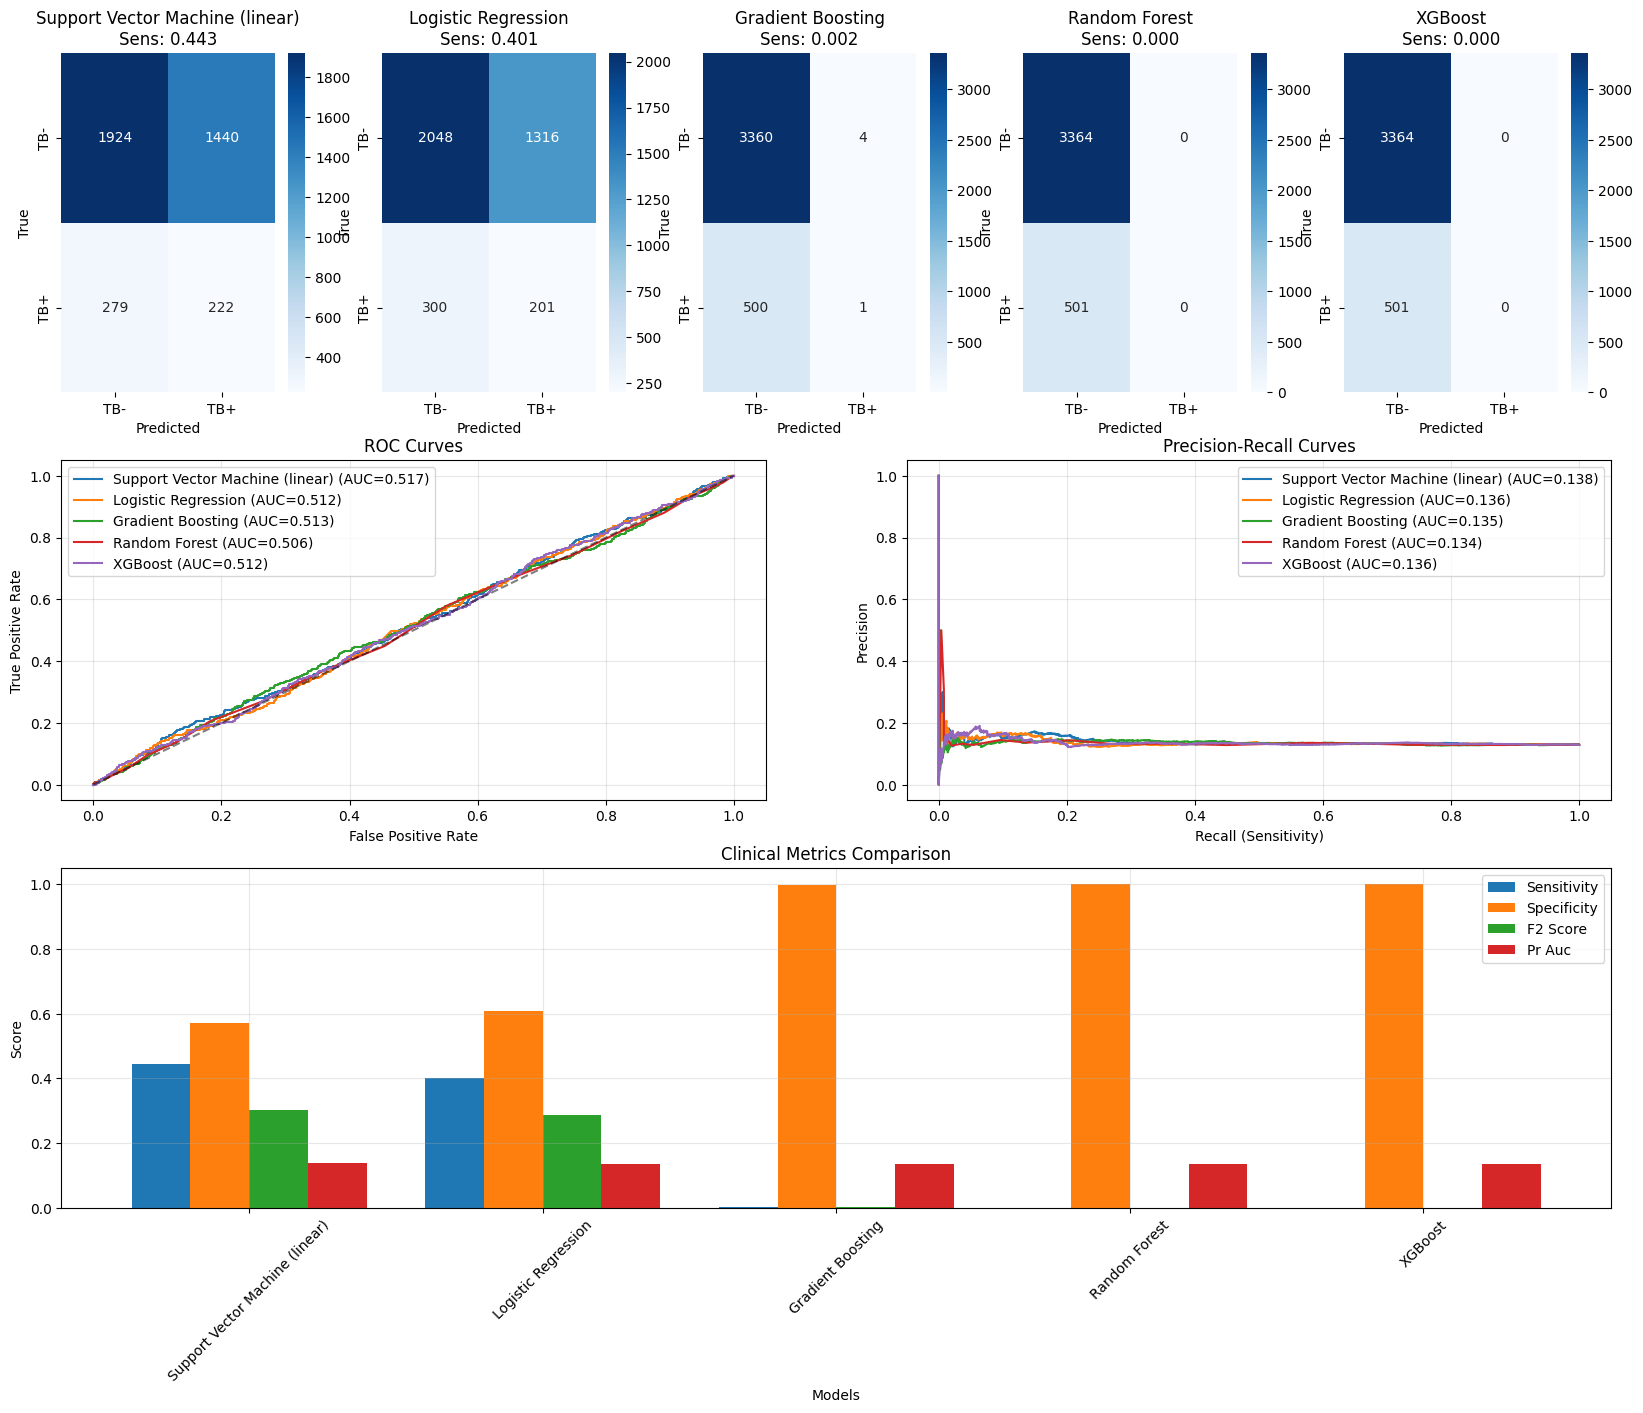

In [16]:
# Create comprehensive visualization dashboard
fig = plt.figure(figsize=(20, 15))

# 1. Confusion Matrices
for i, (name, result) in enumerate(results.items()):
    ax = plt.subplot(3, 5, i+1)
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['TB-', 'TB+'], yticklabels=['TB-', 'TB+'])
    plt.title(f'{name}\nSens: {result["sensitivity"]:.3f}')
    plt.ylabel('True')
    plt.xlabel('Predicted')

# 2. ROC Curves
ax_roc = plt.subplot(3, 2, 3)
for name, result in results.items():
    if not np.isnan(result['roc_auc']):
        # Calculate ROC curve
        if 'SVM' in name or 'Logistic' in name:
            test_data = X_test_scaled
        else:
            test_data = X_test
        
        if hasattr(trained_models[name], "predict_proba"):
            y_prob = trained_models[name].predict_proba(test_data)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            plt.plot(fpr, tpr, label=f'{name} (AUC={result["roc_auc"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Precision-Recall Curves
ax_pr = plt.subplot(3, 2, 4)
for name, result in results.items():
    if not np.isnan(result['pr_auc']):
        # Calculate PR curve
        if 'SVM' in name or 'Logistic' in name:
            test_data = X_test_scaled
        else:
            test_data = X_test
        
        if hasattr(trained_models[name], "predict_proba"):
            y_prob = trained_models[name].predict_proba(test_data)[:, 1]
            precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
            plt.plot(recall_vals, precision_vals, label=f'{name} (AUC={result["pr_auc"]:.3f})')

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Clinical Metrics Comparison
ax_metrics = plt.subplot(3, 1, 3)
metrics = ['sensitivity', 'specificity', 'f2_score', 'pr_auc']
x = np.arange(len(results))
width = 0.2

for i, metric in enumerate(metrics):
    values = [results[name][metric] for name in results.keys()]
    plt.bar(x + i*width, values, width, label=metric.replace('_', ' ').title())

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Clinical Metrics Comparison')
plt.xticks(x + width*1.5, list(results.keys()), rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Clinical Decision Analysis

In [17]:
print("🏥 CLINICAL DECISION ANALYSIS")
print("=" * 50)
print()

# Calculate clinical metrics
total_tb_cases = sum(y_test)
total_negative = len(y_test) - total_tb_cases

print(f"📊 Test Set Overview:")
print(f"  Total patients: {len(y_test)}")
print(f"  TB Positive: {total_tb_cases} ({total_tb_cases/len(y_test)*100:.1f}%)")
print(f"  TB Negative: {total_negative} ({total_negative/len(y_test)*100:.1f}%)")
print()

print("🎯 CRITICAL ANALYSIS - TB Detection Performance:")
print()

for name, result in results.items():
    missed_tb = result['fn']
    detected_tb = result['tp']
    false_alarms = result['fp']
    
    print(f"📋 {name}:")
    print(f"  ✅ TB Cases Detected: {detected_tb}/{total_tb_cases} ({detected_tb/total_tb_cases*100:.1f}%)")
    print(f"  ❌ TB Cases Missed: {missed_tb} ({missed_tb/total_tb_cases*100:.1f}%)")
    print(f"  ⚠️  False Alarms: {false_alarms} ({false_alarms/total_negative*100:.1f}%)")
    print(f"  🎯 Clinical Risk: {'HIGH' if missed_tb > total_tb_cases*0.1 else 'MODERATE' if missed_tb > 0 else 'LOW'}")
    print()

# Recommendations
print("🎯 CLINICAL RECOMMENDATIONS:")
print()

# Find model with best sensitivity
best_sens_model = max(results.items(), key=lambda x: x[1]['sensitivity'])
best_f2_model = max(results.items(), key=lambda x: x[1]['f2_score'])
best_pr_model = max(results.items(), key=lambda x: x[1]['pr_auc'])

print(f"🏆 Recommended for TB Screening: {best_sens_model[0]}")
print(f"   Reason: Highest sensitivity ({best_sens_model[1]['sensitivity']:.3f}) - minimizes missed TB cases")
print()

print(f"🏆 Recommended for Clinical Balance: {best_f2_model[0]}")
print(f"   Reason: Best F2-score ({best_f2_model[1]['f2_score']:.3f}) - balances sensitivity and precision")
print()

print(f"🏆 Recommended for Overall Performance: {best_pr_model[0]}")
print(f"   Reason: Best PR-AUC ({best_pr_model[1]['pr_auc']:.3f}) - best overall discriminative ability")
print()

# Clinical thresholds
print("📋 Clinical Performance Thresholds:")
print("  🎯 Minimum Sensitivity for TB Screening: 0.80 (80%)")
print("  🎯 Target Specificity: 0.85 (85%)")
print("  🎯 Acceptable False Negative Rate: <10%")
print()

# Check which models meet clinical criteria
clinical_pass = []
for name, result in results.items():
    if result['sensitivity'] >= 0.80 and result['specificity'] >= 0.85:
        clinical_pass.append(name)

if clinical_pass:
    print(f"✅ Models meeting clinical criteria: {', '.join(clinical_pass)}")
else:
    print("❌ No models currently meet minimum clinical criteria")
    print("   Recommendation: Apply threshold optimization or ensemble methods")

🏥 CLINICAL DECISION ANALYSIS

📊 Test Set Overview:
  Total patients: 3865
  TB Positive: 501 (13.0%)
  TB Negative: 3364 (87.0%)

🎯 CRITICAL ANALYSIS - TB Detection Performance:

📋 Support Vector Machine (linear):
  ✅ TB Cases Detected: 222/501 (44.3%)
  ❌ TB Cases Missed: 279 (55.7%)
  ⚠️  False Alarms: 1440 (42.8%)
  🎯 Clinical Risk: HIGH

📋 Logistic Regression:
  ✅ TB Cases Detected: 201/501 (40.1%)
  ❌ TB Cases Missed: 300 (59.9%)
  ⚠️  False Alarms: 1316 (39.1%)
  🎯 Clinical Risk: HIGH

📋 Gradient Boosting:
  ✅ TB Cases Detected: 1/501 (0.2%)
  ❌ TB Cases Missed: 500 (99.8%)
  ⚠️  False Alarms: 4 (0.1%)
  🎯 Clinical Risk: HIGH

📋 Random Forest:
  ✅ TB Cases Detected: 0/501 (0.0%)
  ❌ TB Cases Missed: 501 (100.0%)
  ⚠️  False Alarms: 0 (0.0%)
  🎯 Clinical Risk: HIGH

📋 XGBoost:
  ✅ TB Cases Detected: 0/501 (0.0%)
  ❌ TB Cases Missed: 501 (100.0%)
  ⚠️  False Alarms: 0 (0.0%)
  🎯 Clinical Risk: HIGH

🎯 CLINICAL RECOMMENDATIONS:

🏆 Recommended for TB Screening: Support Vector Machine

## Error Analysis and Model Insights

In [18]:
print("🔍 ERROR ANALYSIS")
print("=" * 50)
print()

# Find best performing model for detailed analysis
best_model_name = max(results.items(), key=lambda x: x[1]['f2_score'])[0]
best_result = results[best_model_name]

print(f"📊 Detailed Analysis of Best Model: {best_model_name}")
print()

# False negative analysis (missed TB cases)
if best_result['fn'] > 0:
    print(f"❌ False Negatives (Missed TB Cases): {best_result['fn']}")
    print("   These are the most critical errors in TB detection")
    print("   Clinical Impact: Delayed treatment, continued transmission")
else:
    print("✅ No False Negatives - All TB cases detected!")

print()

# False positive analysis
if best_result['fp'] > 0:
    print(f"⚠️  False Positives (False Alarms): {best_result['fp']}")
    print("   Clinical Impact: Unnecessary testing, patient anxiety, resource waste")
    false_positive_rate = best_result['fp'] / (best_result['fp'] + best_result['tn'])
    print(f"   False Positive Rate: {false_positive_rate:.3f} ({false_positive_rate*100:.1f}%)")
else:
    print("✅ No False Positives - Perfect specificity!")

print()

# Model comparison insights
print("🔬 MODEL INSIGHTS:")
print()

sensitivities = [result['sensitivity'] for result in results.values()]
specificities = [result['specificity'] for result in results.values()]
f2_scores = [result['f2_score'] for result in results.values()]

print(f"📈 Sensitivity Range: {min(sensitivities):.3f} - {max(sensitivities):.3f}")
print(f"📉 Specificity Range: {min(specificities):.3f} - {max(specificities):.3f}")
print(f"🎯 F2-Score Range: {min(f2_scores):.3f} - {max(f2_scores):.3f}")
print()

# Performance variability
sens_std = np.std(sensitivities)
spec_std = np.std(specificities)

print(f"📊 Performance Variability:")
print(f"   Sensitivity Std: {sens_std:.3f}")
print(f"   Specificity Std: {spec_std:.3f}")

if sens_std < 0.05 and spec_std < 0.05:
    print("   ✅ Low variability - models perform consistently")
elif sens_std > 0.15 or spec_std > 0.15:
    print("   ⚠️  High variability - significant differences between models")
else:
    print("   📊 Moderate variability - some model differences")

print()

# Improvement recommendations
print("🎯 IMPROVEMENT RECOMMENDATIONS:")
print()

avg_sensitivity = np.mean(sensitivities)
if avg_sensitivity < 0.80:
    print("🔧 PRIORITY: Improve Sensitivity (TB Detection Rate)")
    print("   - Apply SMOTE or ADASYN for data augmentation")
    print("   - Adjust classification thresholds")
    print("   - Use ensemble methods")
    print("   - Consider cost-sensitive learning")
    print()

avg_specificity = np.mean(specificities)
if avg_specificity < 0.85:
    print("🔧 SECONDARY: Improve Specificity (Reduce False Alarms)")
    print("   - Feature selection to reduce noise")
    print("   - Regularization techniques")
    print("   - Cross-validation for better generalization")
    print()

if max(f2_scores) < 0.60:
    print("🔧 CRITICAL: Overall performance below clinical threshold")
    print("   - Consider multi-modal approaches (audio + clinical data)")
    print("   - Advanced feature engineering")
    print("   - Deep learning approaches")
    print("   - Larger, more diverse training datasets")
else:
    print("✅ Good overall performance achieved")
    print("   Continue with threshold optimization and validation")

🔍 ERROR ANALYSIS

📊 Detailed Analysis of Best Model: Support Vector Machine (linear)

❌ False Negatives (Missed TB Cases): 279
   These are the most critical errors in TB detection
   Clinical Impact: Delayed treatment, continued transmission

⚠️  False Positives (False Alarms): 1440
   Clinical Impact: Unnecessary testing, patient anxiety, resource waste
   False Positive Rate: 0.428 (42.8%)

🔬 MODEL INSIGHTS:

📈 Sensitivity Range: 0.000 - 0.443
📉 Specificity Range: 0.572 - 1.000
🎯 F2-Score Range: 0.000 - 0.303

📊 Performance Variability:
   Sensitivity Std: 0.207
   Specificity Std: 0.201
   ⚠️  High variability - significant differences between models

🎯 IMPROVEMENT RECOMMENDATIONS:

🔧 PRIORITY: Improve Sensitivity (TB Detection Rate)
   - Apply SMOTE or ADASYN for data augmentation
   - Adjust classification thresholds
   - Use ensemble methods
   - Consider cost-sensitive learning

🔧 SECONDARY: Improve Specificity (Reduce False Alarms)
   - Feature selection to reduce noise
   - R

## Final Recommendations and Next Steps

In [19]:
print("📋 FINAL RECOMMENDATIONS")
print("=" * 50)
print()

# Rank models by different criteria
sensitivity_ranking = sorted(results.items(), key=lambda x: x[1]['sensitivity'], reverse=True)
f2_ranking = sorted(results.items(), key=lambda x: x[1]['f2_score'], reverse=True)
pr_auc_ranking = sorted(results.items(), key=lambda x: x[1]['pr_auc'], reverse=True)

print("🏆 MODEL RANKINGS:")
print()

print("📈 By Sensitivity (TB Detection):")
for i, (name, result) in enumerate(sensitivity_ranking[:3]):
    print(f"   {i+1}. {name}: {result['sensitivity']:.3f}")
print()

print("🎯 By F2-Score (Clinical Balance):")
for i, (name, result) in enumerate(f2_ranking[:3]):
    print(f"   {i+1}. {name}: {result['f2_score']:.3f}")
print()

print("📊 By PR-AUC (Overall Performance):")
for i, (name, result) in enumerate(pr_auc_ranking[:3]):
    print(f"   {i+1}. {name}: {result['pr_auc']:.3f}")
print()

# Production recommendations
print("🚀 PRODUCTION DEPLOYMENT RECOMMENDATIONS:")
print()

top_model = f2_ranking[0]
print(f"✅ Recommended for deployment: {top_model[0]}")
print(f"   F2-Score: {top_model[1]['f2_score']:.3f}")
print(f"   Sensitivity: {top_model[1]['sensitivity']:.3f}")
print(f"   Specificity: {top_model[1]['specificity']:.3f}")
print(f"   TB Cases Detected: {top_model[1]['tp']}/{total_tb_cases}")
print()

print("🔧 NEXT STEPS:")
print("1. Threshold optimization for optimal sensitivity/specificity balance")
print("2. Cross-validation with different hospital sites")
print("3. Prospective validation with new patient cohorts")
print("4. Integration with clinical decision support systems")
print("5. Monitoring and retraining protocols")
print()

print("⚠️  IMPORTANT CLINICAL CONSIDERATIONS:")
print("- TB detection models require high sensitivity (>90% preferred)")
print("- False negatives have severe clinical consequences")
print("- Model should complement, not replace, clinical judgment")
print("- Regular performance monitoring in clinical settings required")
print("- Consider ensemble approaches for improved robustness")

print("\n" + "=" * 50)
print("📊 ANALYSIS COMPLETE")
print("=" * 50)

📋 FINAL RECOMMENDATIONS

🏆 MODEL RANKINGS:

📈 By Sensitivity (TB Detection):
   1. Support Vector Machine (linear): 0.443
   2. Logistic Regression: 0.401
   3. Gradient Boosting: 0.002

🎯 By F2-Score (Clinical Balance):
   1. Support Vector Machine (linear): 0.303
   2. Logistic Regression: 0.285
   3. Gradient Boosting: 0.002

📊 By PR-AUC (Overall Performance):
   1. Support Vector Machine (linear): 0.138
   2. Logistic Regression: 0.136
   3. XGBoost: 0.136

🚀 PRODUCTION DEPLOYMENT RECOMMENDATIONS:

✅ Recommended for deployment: Support Vector Machine (linear)
   F2-Score: 0.303
   Sensitivity: 0.443
   Specificity: 0.572
   TB Cases Detected: 222/501

🔧 NEXT STEPS:
1. Threshold optimization for optimal sensitivity/specificity balance
2. Cross-validation with different hospital sites
3. Prospective validation with new patient cohorts
4. Integration with clinical decision support systems
5. Monitoring and retraining protocols

⚠️  IMPORTANT CLINICAL CONSIDERATIONS:
- TB detection mod